In [1]:
import numpy as np
from modules import Cannon, Pressure, WaveLong, WaveTang
import matplotlib.pyplot as plt
from scipy.linalg import solve

# 1. Ballistic and Geometry

In [2]:
d = 125*1e-3          # калибр м
q = 7.05           # вес снаряда кг
velocity_pm = 1700         # дульная скорость снаряда
n_s = 1           # нарезное орудие
max_pressure = 600*1e6    # максимальное давление Па
tube_lenght = 5543*1e-3      # длина трубы     
p_fors = 10*1e6
l_pr = 0.7 # длина снаряда

pow_name = "МАП-1 23/1"
wq, ro = 1.178537, 737.374805

rho = 7800
E = 200e9
vi = 0.25
g = 9.81

# geometry grid
n_x = 500

init_dict = {
   'powders': 
    [
       {'omega': wq*q,
       'dbname': pow_name}
    ],
    'init_conditions': 
    {
       'q': q,
       'd': d,
       'W_0': wq*q/ro,
       'phi_1': 1.0,
       'p_0': p_fors, 
       'n_S': n_s
    },
    'igniter': 
    {
       'p_ign_0': 5_000_000.0 #check it 
    },
  
    'meta_lagrange': 
    {
       'CFL': 0.9, 
       'n_cells': 300
    },
    'stop_conditions': 
    {
       'x_p': tube_lenght,
       'steps_max': 8000,   
       't_max': 0.08,
       'p_max': max_pressure,
    }
    }

In [3]:
Cannon.ro = rho
ball = Pressure(init_dict)
ball.calculate()
geometry = Cannon()
geometry.cannon_geometry(d, ball.l0, ball.l_tube)
ball.make_func(geometry.l_kam, l_pr)

beam_r2_x = np.array([0, 0.4, 0.5, 0.8, geometry.r_inside_coordinate[-1]])
beam_r2 = np.array([0.16, 0.16, 0.16, 0.14, 0.09])
geometry.outside_geometry(beam_r2_x, beam_r2)
geometry.make_func()
geometry.make_dsdx(n_x)

# 3. Wave x (long)

In [4]:
displ = 0 
n_t = 500

dt = ball.t_end/n_t
T = ball.t_end # time stop
T_st = 1
L = geometry.L - displ
C = 0.75 # the Courant number (=max(c)*dt/dx).

### Solve euption

In [5]:
%%time
wave_x = WaveLong(geometry, T, dt, T_st, mass_on=True, fi=np.pi/4)
wave_x.add_pressure(ball, projectile=False)
wave_x.solver()


 T: 0.008
 T_st: 1
 Mass: True
 Pressure: True

N_x =  59
CPU times: total: 39 s
Wall time: 39.3 s


In [6]:
wave_x.grid_u.shape, wave_x.grid_t[100_000:].shape

((63660, 60), (0,))

In [7]:
def u(x, t):
    if t < 0:
        return np.zeros_like(x)
    points = np.array([x, (t+wave_x.T_st)*np.ones_like(x)]).T
    return wave_x.u(points)

In [8]:
u(6, ball.t_end/1.2)

array([-0.00015384])

### Vizualization

In [12]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [13]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [14]:
plt.ioff()

i_start = wave_x.grid_u.shape[0] - round(T/wave_x.dt)

step_slider = widgets.IntSlider(
    orientation='horizontal',
    value=0, 
    min=0, max=wave_x.grid_t[i_start:].shape[0], step=1, 
    description='step'
)

step_slider.layout.margin = '0px 30% 0px 30%'
step_slider.layout.width = '40%'

fig = plt.figure(figsize=(10,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
#plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))

#line1 = plt.plot(grid_x, u[0]*1e6, lw=1)
line2 = plt.plot(wave_x.grid_x, wave_x.grid_u[i_start]*1e6, lw=1)

plt.xlabel('$x$, м', fontsize=16)
plt.ylabel('$u$, мкм', fontsize=16)
plt.xlim(0, 7)
plt.ylim(-200, 200)
plt.grid()


def update_lines(change):
    #plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))
    #line1[0].set_data(grid_x, u[change.new]*1e6)
    line2[0].set_data(wave_x.grid_x, wave_x.grid_u[i_start+change.new]*1e6)
    fig.canvas.draw()
    fig.canvas.flush_events()

step_slider.observe(update_lines, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=step_slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(IntSlider(value=0, description='step', layout=Layout(grid_area='footer', margin='0px 30% 0…

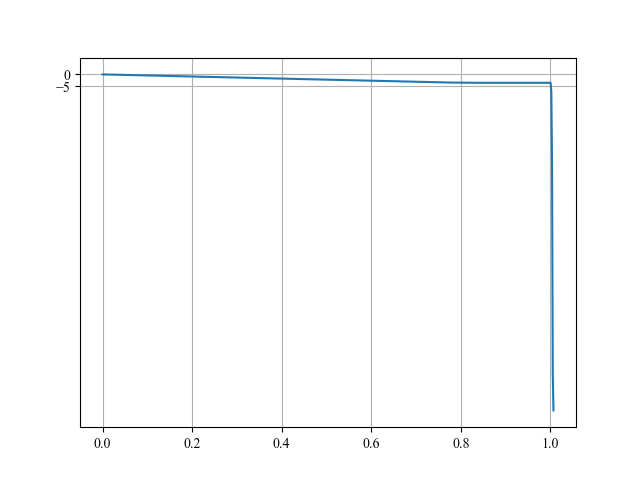

In [15]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
fig2, ax = plt.subplots(1,1)
ax.plot(wave_x.grid_t[::100], wave_x.grid_u[::100,-1]*1e6)
ax.set_yticks(np.arange(-5, 5, 5))
plt.grid()
plt.show()

# 4. Wave y (tang)

In [208]:
class WaveTang():
    
    rho = 7800
    E = 200e9
    vi = 0.25
    g = 9.81
    
    def __init__(self, L, T, dt, F, S, J, u, p, f, C=0.75, dx_user=None):
        
        # --- Compute time and space mesh ---
        self.Nt = int(round(T/dt))
        self.t = np.linspace(0, self.Nt*dt, self.Nt+1)      # Mesh points in time
        # --- Matrix for v(x, t) --
        self.grid_v = []
        # --- Find dx ---
        
        JF_max = max([J(x_)/F(x_) for x_ in np.linspace(0, L, 101)])
        dx = dt*np.sqrt(self.E*JF_max/self.rho)/C
        if isinstance(dx_user, (float, int)):
            dx = dx_user #min(dx, dx_user)
        self.Nx = int(round(L/dx))
        self.x = np.linspace(0, L, self.Nx+1)          # Mesh points in space
        # Make sure dx and dt are compatible with x and t
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
        # Add geometry
        self.F = F(self.x)
        self.S = S(self.x)
        self.J = J(self.x)
        # Add function
        self.fun_u = u
        self.fun_p = p
        self.fun_f = f
    
    def save_layer(self, v):
        self.grid_v.append(v.copy())
        
    def init_condition(self, v_0 = None):
        
        if v_0 is None:
            v_0 = np.zeros(self.Nx+1) 
        elif v_0.shape[0] != self.x.shape[0]:
            raise ValueError(f'different shape u0={u_0.shape[0]} and x={self.x.shape[0]}')
        # --- Allocate memomry for solutions ---
        self.v     = np.zeros(self.Nx+1)   # Solution array at new time level
        self.v_n   = np.zeros(self.Nx+1)   # Solution at 1 time level back
        self.v_nm1 = np.zeros(self.Nx+1)   # Solution at 2 time levels back

        # --- Valid indices for space and time mesh ---
        self.Ix = self.Nx+1
        self.It = self.Nt+1

        # --- Load initial condition into v_n and v_nm1 ---
        self.v_n = v_0 + self.dt*self.fun_f(self.x, self.t[0])/2\
                            /self.rho/self.F               
        self.v_n[:2] = 0
        self.v_nm1 = v_0
        
    def solver(self, max_iter=None):
        
        if not self.grid_v: 
            self.grid_v = []
            
        # add to matrix init condition
        self.save_layer(self.v_nm1)
        self.save_layer(self.v_n)
        
        dx2, dt2 = self.dx**2, self.dt**2
        du_dx = np.zeros_like(self.x)
        # --- Time loop ---
        It = self.It
        if isinstance(max_iter, (int, float)):
            It = min(max_iter, It)
        for n in range(1, It-1):
            u = self.fun_u(self.x, self.t[n])
            p = self.fun_p(self.x, self.t[n]) 
            f = self.fun_f(self.x, self.t[n])*dt2 + self.rho*self.F*\
                    (2*self.v_n - self.v_nm1)
            omega = self.E*self.F*self.du_dx(u, self.dx) - self.S*p
            # --- solv x layer ---
            self.v = self.solver_matrix(self.dx, dt2, self.Ix, self.J, omega, self.F, f, self.E, self.rho)
            # save
            self.save_layer(self.v)
            # Update data structures for next step
            self.v_nm1 = self.v_n
            self.v_n = self.v
            self.v = self.v_nm1 # ??
           
    @staticmethod
    def solver_matrix(dx, dt2, Ix, J, Om, F, f, E, rho):
        
        dx2 = dx*dx
        dx4 = dx**4
        C1 = dt2/dx2
        C2 = dt2/dx4
        # empty layer
        v_x = np.zeros(Ix)
        # allocate memory for coefficients
        a = np.zeros(Ix)
        b = np.zeros(Ix)
        c = np.zeros(Ix)
        d = np.zeros(Ix)
        e = np.zeros(Ix)
        # calculate coefficients
        a[2:] = C2*E*J[1:-1]
        b[1:] = -C1*(2*E/dx2 * (J[1:]+J[:-1]) + 0.5*(Om[1:] + Om[:-1]))
        c[1:-1] = rho*F[1:-1] + C1*0.5*(Om[0:-2] + 2*Om[1:-1] + Om[2:]) +\
                    E*C2*(J[2:] + 4*J[1:-1] + J[0:-2])
        d[:-1] = -C1*(2*E/dx2 * (J[1:]+J[:-1]) + 0.5*(Om[:-1] + Om[1:]))
        e[:-2] = C2*E*J[1:-1]
        # boundary condition for c[0]=0, c[I]
        c[-1] = rho*F[-1] + C1*0.5*(Om[-2]+2*Om[-1]) + E*C2*(4*J[-1]+J[-2])
        # --- calculate v_x ---
        A = np.zeros((Ix-2, Ix))
        for i in range(2,Ix-2):
                A[i-2][i-2:i+3] = np.array([
                        a[i], b[i], c[i], d[i], e[i]
                    ])
        A = np.delete(A,[0,1],1)
        A[-2,-4:] = [-J[-2], (J[-1]+2*J[-2]), -(J[-2]+2*J[-1]), J[-1]]
        A[-1,-3:] = [1, -2, 1]
        f_new = f[2:]
        f_new[-2:] = 0 
        # solve equption
        v_new = solve(A, f_new.reshape((f_new.shape[0],1)))
        v_x[2:] = v_new.reshape(-1)
        return v_x
    
    @staticmethod
    def du_dx(u_x, dx):
        dudx = np.zeros(u_x.shape[0]+2)
        dudx[1:-1] = u_x
        dudx[-1] = u_x[-1]
        dudx = np.roll(dudx, -2) - dudx
        return dudx[:-2]/2/dx
    
    def get_grid(self):
        return np.array(self.grid_v)

def find_A(u, x):
    
    arr_u = []
    arr_x = []
    add = False 
    b = u[-1]
    c = x[-1]
    for i in range(len(u)-1, -1, -1):
        if u[i] > b:
            add = True
            b = u[i]
            c = x[i]
        elif add:
            add = False
            arr_u.append(b)
            arr_x.append(c)
    return np.array(arr_u[::-1]), np.array(arr_x[::-1])

In [9]:
def find_A(u, x):
    
    arr_u = []
    arr_x = []
    add = False 
    b = u[-1]
    c = x[-1]
    for i in range(len(u)-1, -1, -1):
        if u[i] > b:
            add = True
            b = u[i]
            c = x[i]
        elif add:
            add = False
            arr_u.append(b)
            arr_x.append(c)
    return np.array(arr_u[::-1]), np.array(arr_x[::-1])

In [54]:
T_st = 4
T = 5*ball.t_end
dt = T/2000
dx = 1e-2

In [55]:
T, dt, dx

(0.03958237968393724, 1.979118984196862e-05, 0.01)

In [47]:
wave_y = WaveTang(geometry, T, dt,T_st=T_st, dx_user=dx, mass_on=True)
wave_y.add_pressure(ball, u, projectile=True)
wave_y.init_condition()

In [48]:
wave_y.Nt, wave_y.Nx, wave_y.dx, wave_y.dt

(51028, 127, 0.05004554941726483, 7.916475936787448e-05)

In [49]:
%%time
wave_y.solver()

CPU times: total: 27 s
Wall time: 27.1 s


### Vizualization

In [27]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [28]:
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [30]:
plt.ioff()

step_slider = widgets.IntSlider(
    orientation='horizontal',
    value=0, 
    min=0, max=wave_y.Nt, step=1, 
    description='step'
)

step_slider.layout.margin = '0px 30% 0px 30%'
step_slider.layout.width = '40%'

fig = plt.figure(figsize=(10,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
#plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))

line1 = plt.plot(wave_y.grid_x, wave_y.grid_v[0]*1e6, lw=1)

plt.xlabel('$x$, м', fontsize=16)
plt.ylabel('$u$, мкм', fontsize=16)
plt.xlim(0, 7)
plt.ylim(-100, 100)
plt.grid()


def update_lines(change):
    #plt.title('Plotting step: {}'.format(data_x[step_slider.value]['t_s']))
    line1[0].set_data(wave_y.grid_x, wave_y.grid_v[change.new]*1e6)
    fig.canvas.draw()
    fig.canvas.flush_events()

step_slider.observe(update_lines, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=step_slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(IntSlider(value=0, description='step', layout=Layout(grid_area='footer', margin='0px 30% 0…

In [50]:
ampl, x_ampl = find_A(wave_y.grid_v[:,-1], wave_y.grid_t)

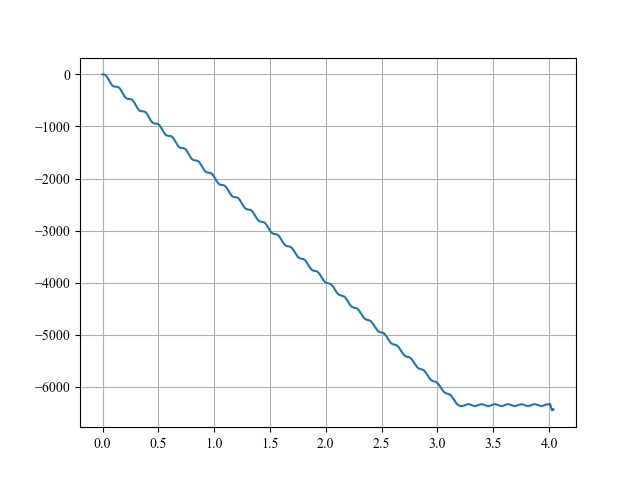

In [53]:
fig2, ax = plt.subplots(1,1)
ax.plot(wave_y.grid_t[:], wave_y.grid_v[:,-1]*1e6)
#plt.yticks(np.arange(-5, 5, 0.5))
#ax.scatter(x_ampl, ampl*1e6)
#plt.ylim(-7000, -6000)
plt.grid()
plt.show()

In [24]:
dicrement = np.mean(ampl[:-1]/ampl[1:])
dicrement

1.1005105076615704

### Test

In [220]:
i = 500
x_grid = wave_y.x
t_p = wave_y.t[i]

In [221]:
u_test = func_u(x_grid, t_p) 
omega = E*F(x_grid)*WaveTang.du_dx(u_test, wave_y.dx) - S(x_grid)*p(x_grid,t_p)

In [222]:
omega

array([-3.00406930e+06, -3.19713014e+06, -3.15534416e+06, -3.11277865e+06,
       -3.05681856e+06, -3.00496960e+06, -2.93972863e+06, -2.84684137e+06,
       -2.77498962e+06, -2.35153389e+06, -2.31723603e+06, -2.23815062e+06,
       -2.11587462e+06, -1.98250805e+06, -1.86918596e+06, -1.73381970e+06,
       -1.60620551e+06, -1.47521610e+06, -1.33571320e+06, -1.21218431e+06,
       -1.06584831e+06, -8.89977664e+05, -7.20824940e+05, -5.50678802e+05,
       -3.52502965e+05, -1.45730897e+05,  1.46991608e+04,  3.34004480e+04,
        3.76463383e+04,  4.50981959e+04,  4.77968088e+04,  3.98870869e+04,
        2.15183719e+04,  1.33687698e+04,  1.92584264e+04,  2.46835880e+04,
        2.73727976e+04,  3.06382201e+04,  2.55662721e+04,  2.31127272e+03,
        1.31999838e+03,  2.20378171e+04,  1.70471487e+04,  2.05491178e+04,
        3.64657297e+04,  3.72787596e+04,  2.62896322e+04,  1.19798510e+04,
        6.89339755e+03,  6.19758330e+03,  9.95827715e+03,  1.02135290e+04,
        7.33640287e+03,  